<a href="https://colab.research.google.com/github/royseto/langgraph-tutorials-royseto/blob/main/LangGraph_Multiply_Tool_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab notebook has Roy's work with the LangGraph Quickstart at https://langchain-ai.github.io/langgraph/tutorials/introduction/

It starts with part 2, and pulls forward the refactoring from part 3 to use prebuilt funtions and classes for tool use.

# Setup

In [15]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

In [16]:
import os
from google.colab import userdata

os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langgraph-quickstart"

REMOVE

For Tavily hello world notebook, see https://colab.research.google.com/drive/1P16Y23P-1uSGLkQI50y0IUc3FdYgBGTW

"Tavily Search API is a search engine optimized for LLMs, aimed at efficient, quick and persistent search results." - https://docs.tavily.com/docs/welcome

In [ ]:
"""
%%capture --no-stderr
%pip install -U tavily-python langchain_community
"""

In [ ]:
"""
import os
from google.colab import userdata
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
"""

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [18]:
from langchain_core.tools import tool


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


# Let's inspect some of the attributes associated with the tool.
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply two numbers.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


In [19]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#tool = TavilySearchResults(max_results=2)
tool = multiply
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [20]:
graph = graph_builder.compile(checkpointer=memory)

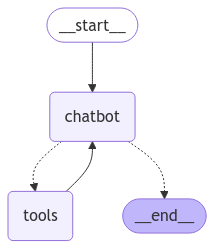

In [21]:
graph

In [22]:
config = {"configurable": {"thread_id": "1"}}

In [23]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or any task you need help with?


In [24]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, Will! I'll remember that your name is Will throughout our conversation. Is there anything in particular you'd like to discuss or any questions you have? I'm here to help with a wide range of topics or tasks.


In [25]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='ac914a9d-3f1f-41e4-afee-f1f4f187238e'), AIMessage(content="Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or any task you need help with?", additional_kwargs={}, response_metadata={'id': 'msg_01VYUaqk1ftac7HDN4yAUGZM', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 372, 'output_tokens': 37}}, id='run-319a849e-1ad8-45a1-9f93-ac3ff4ae52bd-0', usage_metadata={'input_tokens': 372, 'output_tokens': 37, 'total_tokens': 409, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='4b751d8c-2df2-4546-9a45-ce0ea6f260c1'), AIMessage(content="Of course, Will! I'll remember that 

In [26]:
user_input = "what is 6 * 7?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is 6 * 7?
================================== Ai Message ==================================

[{'text': "To calculate 6 * 7, I can use the multiply function that's available to me. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01Hkq2W2rPtL64fBQMY2maog', 'input': {'a': 6, 'b': 7}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01Hkq2W2rPtL64fBQMY2maog)
 Call ID: toolu_01Hkq2W2rPtL64fBQMY2maog
  Args:
    a: 6
    b: 7
================================= Tool Message =================================
Name: multiply

42
================================== Ai Message ==================================

The result of 6 * 7 is 42.

Is there anything else you'd like to calculate or any other questions you have, Will?


In [27]:
user_input = "tell me about flamingos"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

tell me about flamingos
================================== Ai Message ==================================

Certainly, Will! I'd be happy to tell you about flamingos. Flamingos are fascinating birds known for their distinctive pink coloration and unique appearance. Here are some interesting facts about flamingos:

1. Appearance: Flamingos are known for their long necks, stilt-like legs, and most notably, their pink or reddish color. They have a curved beak that they use for filter feeding.

2. Color: Their pink color comes from the food they eat. Flamingos get their rosy hue from carotenoid pigments in the algae and small crustaceans that make up their diet.

3. Habitat: Flamingos are found in warm, watery regions on many continents. They prefer shallow lakes, mangrove swamps, and coastal lagoons.

4. Species: There are six species of flamingo in the world, found in areas of Africa, Asia, Europe, and the Am

In [28]:
user_input = "is 6*8 greater than 7 * 7?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

is 6*8 greater than 7 * 7?
================================== Ai Message ==================================

[{'text': "To answer this question, Will, we need to calculate both 6*8 and 7*7, and then compare the results. Let's use the multiply function to do these calculations.", 'type': 'text'}, {'id': 'toolu_01WDZ9dsWA3cZEGDV3rRU9c1', 'input': {'a': 6, 'b': 8}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01WDZ9dsWA3cZEGDV3rRU9c1)
 Call ID: toolu_01WDZ9dsWA3cZEGDV3rRU9c1
  Args:
    a: 6
    b: 8
================================= Tool Message =================================
Name: multiply

48
================================== Ai Message ==================================

[{'text': "The result of 6 * 8 is 48.\n\nNow, let's calculate 7 * 7:", 'type': 'text'}, {'id': 'toolu_011Gb1ZocCXVnsiEbUC1Xnqg', 'input': {'a': 7, 'b': 7}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls

In [30]:
def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config
    ):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: is 4 * 5 equal to 5 * 4?
Assistant: [{'text': "To answer this question, Will, we need to calculate both 4 * 5 and 5 * 4 using the multiply function, and then compare the results. Let's do that:", 'type': 'text'}, {'id': 'toolu_014UUEQRf48nsGugCyuHwwxN', 'input': {'a': 4, 'b': 5}, 'name': 'multiply', 'type': 'tool_use'}]
Assistant: 20
Assistant: [{'text': "The result of 4 * 5 is 20.\n\nNow, let's calculate 5 * 4:", 'type': 'text'}, {'id': 'toolu_01RRiccbtCL1GUusuChAtbBi', 'input': {'a': 5, 'b': 4}, 'name': 'multiply', 'type': 'tool_use'}]
Assistant: 20
Assistant: The result of 5 * 4 is also 20.

So, to answer your question: Yes, 4 * 5 is equal to 5 * 4. Both calculations result in 20.

This demonstrates an important property of multiplication called the commutative property. The commutative property states that changing the order of the factors does not change the product. In other words, for any two numbers a and b, a * b = b * a.

Is there anything else you'd like to know about 